In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import scipy.io as sio

# Any results you write to the current directory are saved as output.
import random


import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

# from tqdm import tqdm_notebook, tnrange
# from itertools import chain
# from skimage.io import imread, imshow, concatenate_images
# from skimage.transform import resize
# from skimage.morphology import label
# from sklearn.model_selection import train_test_split

import cv2
from PIL import Image
print(Image.__file__)

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator



C:\Users\Rutuja Moharil\Anaconda3\lib\site-packages\PIL\Image.py


Using TensorFlow backend.


# UNET


In [2]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [3]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=False)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=True)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=True)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=True)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=True)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=True)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=True)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=True)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=False)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])

    return model

# Data Generator

In [4]:
def create_generator(batch_size,mask_type = "lv_endo",mode="train",shuffle_var = False):
    #lv_endo 001
    #lv_epi 002
    #rv_endo 003
    #rv_epi 004
#     shuffle_var = False 
    mask_directory = {"lv_endo":1,"lv_epi":2,"rv_endo":3,"rv_epi":4}
    data_gen_args = dict(rescale = 1./255,
                         rotation_range=10,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.2)
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)
    seed = 1
#     if mode == "train":
#         shuffle_var = True 
        
    image_generator = image_datagen.flow_from_directory('mri/'+mode+'/images/',class_mode ='binary',target_size =(192,192),
        color_mode='grayscale',batch_size = batch_size,shuffle = shuffle_var,seed=seed)
#     print('/home/ubuntu/mri/train/train_00'+str(mask_directory[mask_type])+'/masks/masks/')
    mask_generator = mask_datagen.flow_from_directory('mri/'+mode+'/'+mode+'_00'+str(mask_directory[mask_type])+'/masks/',
        class_mode ='binary',target_size =(192,192),color_mode='grayscale',batch_size = batch_size,shuffle = shuffle_var,
        seed=seed)
#     train_generator = zip(image_generator, mask_generator)
    while True:
        yield (image_generator.next()[0], mask_generator.next()[0])

Testing data generator

Found 6930 images belonging to 1 classes.
Found 6930 images belonging to 1 classes.
(16, 192, 192, 1)
(16, 192, 192, 1)


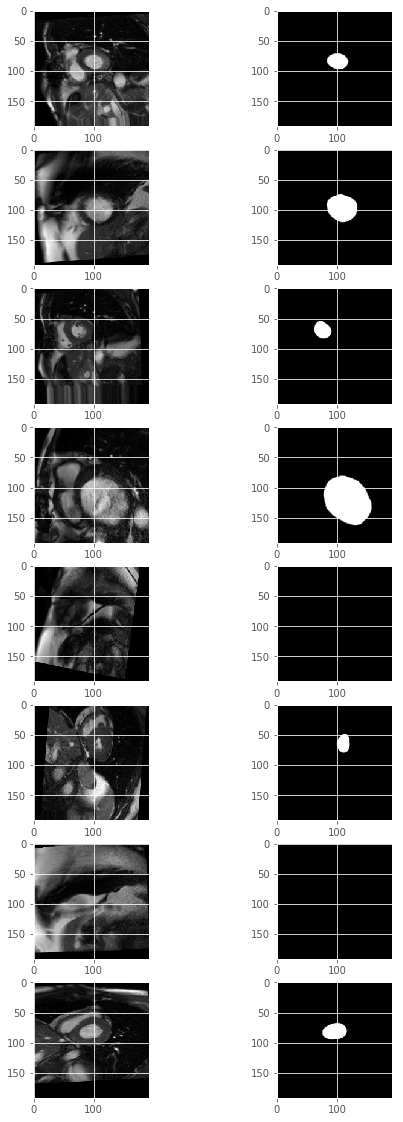

In [5]:
image_gen = np.ones((1,192,192,1))
mask_gen = np.ones((1,192,192,1))
# image_gen = image.reshape(image,(1,image.shape[0],image.shape[1],1))
# mask_gen = image.reshape(mask,(1,image.shape[0],image.shape[1],1))
# image_batch, mask_batch = next(create_generator(image_gen, mask_gen, 8,"lv_endo"))
image_batch, mask_batch = next(create_generator(16,mask_type ="lv_endo",mode="train",shuffle_var=True))
print(mask_batch.shape)
print(image_batch.shape)
fix, ax = plt.subplots(8,2, figsize=(8,20))

for i in range(8):
    ax[i,0].imshow(image_batch[i,:,:,0],cmap = 'gray')
    ax[i,1].imshow(mask_batch[i,:,:,0],cmap = 'gray')
plt.show()

In [6]:
import keras.backend as K
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [7]:
input_img = Input((192, 192, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True)

model.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics=[dice_coef])
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 192, 192, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 192, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 192, 192, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________

In [ ]:
model_rv_epi = model 
model_lv_epi = model
model_rv_endo = model

In [ ]:
batch_size = 16
hist_endo = model.fit_generator(create_generator(batch_size,"lv_endo",mode="train",shuffle_var=True),
                           steps_per_epoch = 6930//batch_size,
                           epochs=10, verbose=1,validation_data = create_generator(batch_size,mask_type ="lv_endo",mode="val"),
                           validation_steps =1470//batch_size)
model.save_weights('lv_endo_newdata10_epochs.h5')

# Training 

In [ ]:
model_lv_epi = get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True)

model_lv_epi.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics=[dice_coef])

In [ ]:
hist_lv_epi = model_lv_epi.fit_generator(create_generator(16,"lv_epi",mode="train",shuffle_var=True),
                           steps_per_epoch = 6930//batch_size,
                           epochs=10, verbose=1,validation_data = create_generator(16,mask_type ="lv_epi",mode="val"),
                           validation_steps = 1470//batch_size)
model_lv_epi.save_weights('lv_epi_newdata10_epochs.h5')

In [ ]:
model_rv_endo = get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True)

model_rv_endo.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics=[dice_coef])

In [ ]:
hist_rv_endo = model_rv_endo.fit_generator(create_generator(16,"rv_endo",mode="train",shuffle_var=True),
                           steps_per_epoch = 6930//batch_size,
                           epochs=10, verbose=1,validation_data = create_generator(16,mask_type ="rv_endo",mode="val"),
                           validation_steps = 1470//batch_size)
model_rv_endo.save_weights('rv_endo_newdata10_epochs.h5')

# Test predictions and Saving the model 

In [8]:
model.load_weights('lv_endo_newdata10_epochs.h5')
# model_lv_epi.load_weights('lv_endo_10_epochs.h5')
# model_rv_endo.load_weights('rv_endo_10_epochs.h5')

In [ ]:
def predict_gen(model,mask_type):
    mask_type_dict = {"lv_endo":["001","a"],"lv_epi":["002","b"],"rv_endo":["003","c"]}
    test_datagen_images = ImageDataGenerator(rescale = 1./255)
    seed = 1
    test_image_generator = test_datagen_images.flow_from_directory('mri/test/images',class_mode ='binary',target_size =(192,192),
                        shuffle =False,color_mode='grayscale',batch_size = 8,seed=seed)

    STEP_SIZE_TEST=test_image_generator.n//8
    lv_endo_predict = model.predict_generator(test_image_generator, steps = test_image_generator.n//8,verbose = 1)
    return lv_endo_predict

In [ ]:
lv_endo_predict = predict_gen(model,mask_type="lv_endo")
# lv_epi_predict,ground_mask_lv_epi=predict_gen(model_lv_epi,mask_type="lv_epi")
# rv_endo_predict,ground_mask_rv_endo=predict_gen(model_rv_endo,mask_type="rv_endo")

In [ ]:
plt.imshow(lv_endo_predict[20][:,:,0])

In [ ]:
# Threshold predictions
def save_to_png(image_array,mask_type):
    dir_to_save='/home/ubuntu/mri/test/'
    mask_type_dict = {"lv_endo":["001","a"],"lv_epi":["002","b"],"rv_endo":["003","c"]}
    dir_to_save = dir_to_save +'seg_'+mask_type_dict[mask_type][0]+'/masks/masks/'
    ind = 0 
    df = pd.read_csv('/home/ubuntu/patient_data_attributes_all.csv',index_col = False)
    df_id_select = df.loc[df.Mode =="test"]
    for study in range(1,int(df_id_select.iloc[-1,:].Image_id[1:5])+1):
        df_select = df.loc[(df.Image_id.str.startswith("i"+str(study).zfill(4)))&(df.Mode=="test"), :]
        for idx in range(len(df_select)):
            df_idx = df_select.iloc[idx,:]
            im = np.where(image_array[ind][:,:,0]>0.35,1,0)
#             im = image_array[ind]
            im = 255*im.reshape(192,192).astype(np.uint8)
            im = Image.fromarray(im)
            im = im.convert("L")
            file_dir = os.path.join(dir_to_save,mask_type_dict[mask_type][1]+df_idx[0][1:]+".png")
            plt.imsave(file_dir, im,cmap=plt.get_cmap('gray'))
#             cv2.imwrite(file_dir, im)
            ind+=1
            print(idx,len(df_select))
    

save_to_png(lv_endo_predict,mask_type="lv_endo")
# lv_endo_datagen=test_datagen_images.flow(lv_endo_predict_thresh,batch_size =batch_size,verbose = 1)

In [ ]:
def plot_history(hist_endo):
    fig,ax = plt.subplots(1,2,figsize=(10, 5),squeeze = False)

    ax[0][0].plot(hist_endo.history["loss"], label="loss")
    ax[0][0].plot(hist_endo.history["val_loss"], label="val_loss")
    ax[0][0].plot( np.argmin(hist_endo.history["val_loss"]), np.min(hist_endo.history["val_loss"]), marker="x", color="r", label="best model")
    ax[0][0].legend();
    ax[0][0].set_xlabel("Epochs")
    ax[0][0].set_ylabel("Loss")
    ax[0][1].plot(hist_endo.history["dice_coef"],label ="dice_coef")
    ax[0][1].plot(hist_endo.history["val_dice_coef"],label ="val_dice_coef")
    ax[0][1].legend();
    # ax.set_legend();
    ax[0][1].set_xlabel("Epochs")
    ax[0][1].set_ylabel("Dice coefficient")
    plt.show()
plot_history(hist_rv_endo)

# Stroke Volume

In [ ]:
def volume_calculation(study,mask_type,mask_mode ="ground"):
    mask_dir='/home/ubuntu/mri/test/'
    ratio_x = 1
    ratio_y = 1
    mask_type_dict = {"lv_endo":["001","a"],"lv_epi":["002","b"],"rv_endo":["003","c"]}
    if mask_mode =="ground":
        mask_dir = mask_dir +'test_'+mask_type_dict[mask_type][0]+'/masks/masks/'
    elif mask_mode=="seg":
        mask_dir = mask_dir +'seg_'+mask_type_dict[mask_type][0]+'/masks/masks/'
    else:
        mask_dir  = None
        
    df = pd.read_csv('/home/ubuntu/patient_data_attributes_all.csv',index_col = False)
    total_volume=[]
    index = 0 
    df_select = df.loc[(df.Image_id.str.startswith("i"+str(study).zfill(4)))&(df.Mode=="test"), :]           
    for phase in range(1,int(df_select.iloc[-1,0][5:8])+1 ):
        voxel_volume = 0
        for slices in range(1,int(df_select.iloc[-1,0][8:])+1):
            filename = str(study).zfill(4)+str(phase).zfill(3)+str(slices).zfill(3)
            mask_val = np.array(Image.open(mask_dir +mask_type_dict[mask_type][1]+filename+'.png' ))
            mask_val = mask_val[:,:,0]
            mask_val = mask_val*1./255
            mask_val = mask_val.reshape(192,192)
            if mask_mode == "ground":
#                 mask_val = np.where(mask_val>0.5,1,0)
#                 mask_val = np.where(mask_val>0.2,1,0)
                area = np.sum(mask_val!=0)
            elif mask_mode =="seg":
                area = np.sum(mask_val==1)
            df_idx = df_select.loc[df_select.Image_id=="i"+filename]
            if (df_idx.Shape_x != 192).bool() or (df_idx.Shape_y != 192).bool():
                ratio_x = 192/df_idx.Shape_x
                ratio_y = 192/df_idx.Shape_y
            V_i = (df_idx.space_between_slice + df_idx.slice_thickness)*area*( df_idx.pixel_size_x *ratio_x*df_idx.pixel_size_y*ratio_y)
            voxel_volume+= V_i.values.tolist()[0]
        total_volume.append(voxel_volume)
    return total_volume 

def stroke_vol_plot(prediction , truth,mask_type="lv_endo",study = 1):
    fig,ax = plt.subplots(1,2,figsize=(12, 6),squeeze = False)
    ax[0][0].plot(truth, label=mask_type+"ground_vol")
    ax[0][0].set_xlabel("Phase")
    ax[0][0].set_ylabel("Volume")
    ax[0][0].set_title(mask_type + f" ground Stroke volume:Study {study}")
    ax[0][1].plot(prediction, label=mask_type+"predicted_vol")
    ax[0][1].set_xlabel("Phase")
    ax[0][1].set_ylabel("Volume")
    ax[0][1].set_title(mask_type+ f" predicted Stroke volume:Study {study}")
    plt.show()

# Ejection Fraction

In [ ]:
# def ejection_fraction(study , mask_type) :
    
#     lv_gnd_vol = volume_calculation(study , mask_type ,mask_mode="ground")
#     ESV_gnd = min(lv_gnd_vol)
#     EDV_gnd = max(lv_gnd_vol)
#     print(f"Ground ESV for study_{study}: {ESV_gnd}" )
#     print(f"Ground EDV for study_{study}: {EDV_gnd}" )
#     print(f"Ground Ejection Fraction  for study_{study}: { (EDV_gnd - ESV_gnd)/EDV_gnd}" )
    
#     lv_pred_vol = volume_calculation(study , mask_type ,mask_mode="seg")
#     ESV_pred = min(lv_pred_vol)
#     EDV_pred = max(lv_pred_vol)

#     print(f"Predicted ESV for study_{study}: {ESV_pred}")
#     print(f"Predicted EDV for study_{study}: {EDV_pred}")
#     print(f"Predicted Ejection Fraction  for study_{study}: {(EDV_pred-ESV_pred)/EDV_pred}" )
#     stroke_vol_plot(lv_pred_vol , lv_gnd_vol ,mask_type="lv_endo",study=study)

#     ef_offset = (EDV_pred-ESV_pred)/EDV_pred - (EDV_gnd - ESV_gnd)/EDV_gnd
#     edv_offset = EDV_gnd - EDV_pred
#     esv_offset = ESV_gnd - ESV_pred
    
#     return ef_offset , edv_offset , esv_offset
    
# # ejection_fraction(study = 2,mask_type="lv_endo")
# # ejection_fraction(study = 3,mask_type="lv_endo")
# offset = []
# for i in range(1,18):
#     ef_off , edv_off , esv_off = ejection_fraction(study = i,mask_type="lv_endo")
#     offset.append((ef_off , edv_off , esv_off))
def ejection_fraction(study , mask_type) :
    
    lv_gnd_vol = volume_calculation(study , mask_type ,mask_mode="ground")
    ESV_gnd = min(lv_gnd_vol)
    EDV_gnd = max(lv_gnd_vol)
#     print(f"Ground ESV for study_{study}: {ESV_gnd}" )
#     print(f"Ground EDV for study_{study}: {EDV_gnd}" )
#     print(f"Ground Ejection Fraction  for study_{study}: { (EDV_gnd - ESV_gnd)/EDV_gnd}" )
    
    lv_pred_vol = volume_calculation(study , mask_type ,mask_mode="seg")
    ESV_pred = min(lv_pred_vol)
    EDV_pred = max(lv_pred_vol)

#     print(f"Predicted ESV for study_{study}: {ESV_pred}")
#     print(f"Predicted EDV for study_{study}: {EDV_pred}")
#     print(f"Predicted Ejection Fraction  for study_{study}: {(EDV_pred-ESV_pred)/EDV_pred}" )
#     stroke_vol_plot(lv_pred_vol , lv_gnd_vol ,mask_type="lv_endo",study=study)

    ef_offset = (EDV_pred-ESV_pred)/EDV_pred - (EDV_gnd - ESV_gnd)/EDV_gnd
    edv_offset = EDV_gnd - EDV_pred
    esv_offset = ESV_gnd - ESV_pred
#    
#     return ef_offset , edv_offset , esv_offset
    return (ESV_gnd ,ESV_pred) , (EDV_gnd,EDV_pred) ,((EDV_gnd - ESV_gnd)/EDV_gnd,(EDV_pred-ESV_pred)/EDV_pred)

 
    
# ejection_fraction(study = 2,mask_type="lv_endo")
# ejection_fraction(study = 3,mask_type="lv_endo")
bland_esv = []
bland_edv = []
bland_ef = []
for i in range(1,18):
    esv , edv , ef = ejection_fraction(study = i,mask_type="lv_endo")
    bland_esv.append(esv)
    bland_edv.append(edv)
    bland_ef.append(ef)

In [ ]:
def bland_altman_plot(data1, data2):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    plt.scatter(mean, diff)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')    
    plt.title("Bland Altman plot")
    pass

In [ ]:
data_1 , data_2 = list(zip(*bland_ef))[0],list(zip(*bland_ef))[1]
bland_altman_plot(data_1, data_2)
x, y = pd.Series(data_1, name="Ground esv"), pd.Series(data_2, name="Pred esv")
ax = sns.regplot(x=x, y=y, color="b").set(title = "EF linear regression")


In [ ]:
def convert_to_nifti(study = 1,mask_type = "lv_endo",mask_mode="ground"):

    mask_dir='/home/ubuntu/mri/test/'

    mask_type_dict = {"lv_endo":["001","a"],"lv_epi":["002","b"],"rv_endo":["003","c"]}
    
    if mask_mode =="ground":
        mask_dir = mask_dir +'test_'+mask_type_dict[mask_type][0]+'/masks/masks/'
    elif mask_mode=="seg":
        mask_dir = mask_dir +'seg_'+mask_type_dict[mask_type][0]+'/masks/masks/'
    
    df = pd.read_csv('CARDIAC_MR IMAGES/patient_data_attributes_all.csv',index_col = False)
   
   
    total_volume=[]
    idx = 0 
    df_select = df.loc[(df.Image_id.str.startswith("i"+str(study).zfill(4)))&(df.Mode=="val"), :]   
    total_stack = np.zeros((192,192,len(df_select)))
    for phase in range(1,int(df_select.iloc[-1,0][5:8])+1 ):
        voxel_volume = 0
        for slices in range(1,int(df_select.iloc[-1,0][8:])+1):
            filename = str(study).zfill(4)+str(phase).zfill(3)+str(slices).zfill(3)
            mask_val = np.array(Image.open(mask_dir + "i"+filename+'.png' ))
            mask_val = mask_val[:,:,0]
            mask_val = mask_val*1./255
            mask_val = mask_val.reshape(192,192)
            total_stack[:,:,idx] = mask_val
            idx+=1

    img = nib.Nifti1Image(total_stack,None)
    nib.save(img,"VA_158.nii")
convert_to_nifti(study =1 ,mask_type = "lv_endo",mask_mode = "ground")

# Display Images 

In [ ]:
index = 0 
fig , ax = plt.subplots(1,2,squeeze = False ,figsize = (10,10))
original_image =  np.array(Image.open('mri/test/images/images/i0015020010.png'))
mask_val_gnd =  np.array(Image.open('mri/test/test_001/masks/masks/a0015020010.png'))
mask_val_gnd = (mask_val_gnd[:,:,0]*1./255).reshape(192,192)
mask_val_pred =  np.array(Image.open('mri/test/seg_001/masks/masks/a0015020010.png'))
mask_val_pred = (mask_val_pred[:,:,0]*1./255).reshape(192,192)

ax[index][0].imshow(original_image[:,:,0]*1./255, 'gray', interpolation='none')
ax[index][0].imshow(mask_val_gnd, 'jet', interpolation='none', alpha=0.3)
ax[index][0].grid(False)

ax[index][1].imshow(original_image, 'gray', interpolation='none')
ax[index][1].imshow(mask_val_pred, 'jet', interpolation='none', alpha=0.3)
ax[index][1].grid(False)
ax[0][0].set_title("Ground")
ax[0][1].set_title("Prediction")
plt.show()

In [3]:
import skimage

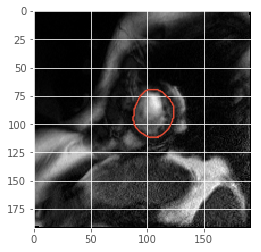

In [34]:
def my_image_to_polygon(dir,threshold):
    img = np.array(Image.open(dir))
    contour = skimage.measure.find_contours(img, threshold)
    # not sure why we need to add 0.5-pixel shift here
    contours = np.array(contour[0]).reshape(-1,2) + 0.5
    return np.flip(contours,1)
contour = my_image_to_polygon('C:/Users/Rutuja Moharil/CARDIAC_MR IMAGES/mri_data/train/train_001/masks/masks/i1000009.png',0.5)
image = np.array(Image.open('C:/Users/Rutuja Moharil/CARDIAC_MR IMAGES/mri_data/train/images/images/i1000009.png'))
plt.imshow(image,cmap ='gray')
plt.plot(contour[:,0],contour[:,1],linewidth = 1.5)

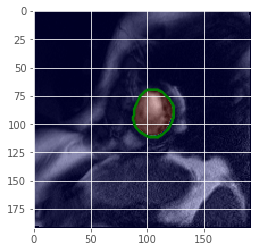

In [39]:
mask = np.array(Image.open('C:/Users/Rutuja Moharil/CARDIAC_MR IMAGES/mri_data/train/train_001/masks/masks/i1000009.png'))
plt.imshow(image,cmap ='gray')
plt.imshow(mask,cmap = 'jet' , alpha = 0.3)
plt.plot(contour[:,0],contour[:,1],linewidth = 2.5,color = 'g')
plt.show()